## Notebook for using DenseNet to tell if the MCA is visible for a slice
Pipeline:
- Import data
- Find volume with the highest cumulative intensity for each patient
- Discard all other volumes
- Perform train, val, test split
- Normalize data <- todo?
- Initialize model
- Train model
- Test model
- Visualize results
- Use KMeans to extract AIFs

In [1]:
# Imports
import torch
import numpy as np
import pandas as pd
import pydicom as pdc
from datahandling_utils import createImageIndexCSV, get_train_test_split_on_patients, get_max_intensity_for_dataset
from dense_net import DenseNet3
from model_utils import train_and_eval

SEED = 41
np.random.seed(SEED)
BATCH_SIZE = 8
EPOCHS = 150
image_path = "D:/iCAT_IMAGES"
aif_path = "D:/AIFs/AIFs/durable/BorrSci_MR_Data/Output"
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Import images (paths)
image_data = createImageIndexCSV(image_path)
# Import annotations
mca_labels = pd.read_excel('MCA_labels.xlsx')
# mca_labels = mca_labels[:12]
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 11].index) # Patient 11 is missing a file
image_data = image_data[image_data['Patient'].isin(mca_labels['Patient'])]

In [3]:
# Change the label dataframe to be compatible with efficient datahandling
mca_labels = pd.melt(mca_labels, id_vars = ['Patient'], var_name='Slice', value_name='Label').sort_values(['Patient', 'Slice'])

In [4]:
vol_intensities = get_max_intensity_for_dataset(image_data)

In [5]:
# Only keep the relevant volumes
from datahandling_utils import filter_on_intensity_and_add_data
extra_vols = 5
copy_data = filter_on_intensity_and_add_data(image_data, mca_labels, vol_intensities, extra_vols)

Added data 1110. Original amount of data 3312


In [6]:
train_images, test_images = get_train_test_split_on_patients(copy_data)

In [7]:
train_labels = np.isin(mca_labels['Patient'], np.unique(train_images['Patient']))
train_labels = mca_labels[train_labels]
test_labels = np.isin(mca_labels['Patient'], np.unique(test_images['Patient']))
test_labels = mca_labels[test_labels]

In [8]:
# Permutate labels
# train_labels['Label'] = train_labels['Label'].sample(frac=1, random_state=SEED).values
# test_labels['Label'] = test_labels['Label'].sample(frac=1, random_state=SEED).values

In [9]:
# from datahandling_utils import filter_on_intensity_and_add_data
# extra_vols = 5
# train_images = filter_on_intensity_and_add_data(train_images, train_labels, vol_intensities, extra_vols)
# test_images = filter_on_intensity_and_add_data(test_images, test_labels, vol_intensities, extra_vols)

In [10]:
label_train_true_size, label_train_size = len(train_labels[train_labels['Label'] == 1]) + len(train_images) - len(train_labels), len(train_images)
label_test_true_size, label_test_size = len(test_labels[test_labels['Label'] == 1]) + len(test_images) - len(test_labels), len(test_images)
print(f"Size training data: {len(train_images)}. Size test_data: {len(test_images)}")
print(f"Number of true labels in training: {label_train_true_size} of {label_train_size} ({round(label_train_true_size/label_train_size, 3)*100}%). True labels in test: {label_test_true_size} of {label_test_size} ({round(label_test_true_size/label_test_size, 3)*100}%)")

Size training data: 3535. Size test_data: 887
Number of true labels in training: 1074 of 3535 (30.4%). True labels in test: 258 of 887 (29.099999999999998%)


In [11]:
from datahandling_utils import SliceIntensityDataset
train_dataset, test_dataset = SliceIntensityDataset(train_images, train_labels), SliceIntensityDataset(test_images, test_labels)

In [12]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
model = DenseNet3(64, num_classes=1, dropRate=0.4)
print(f"Total number of trainable parameters {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Total number of trainable parameters 365737


In [14]:
import torch
torch.cuda.empty_cache()

In [15]:
losses = train_and_eval(model, test_loader, train_loader, EPOCHS, device, apr=True)

Epoch 1 of 150
TP 0, FP 0, TN 629, FN 258
Validation - Accuracy 0.71 Precision 0.0 and Recall 0.0
Training loss 21.982620239257812, validation loss 158.88247680664062

Epoch 2 of 150
TP 0, FP 0, TN 629, FN 258
Validation - Accuracy 0.71 Precision 0.0 and Recall 0.0
Training loss 15.391190528869629, validation loss 183.488037109375

Epoch 3 of 150
TP 0, FP 0, TN 629, FN 258
Validation - Accuracy 0.71 Precision 0.0 and Recall 0.0
Training loss 12.884622573852539, validation loss 125.95372009277344

Epoch 4 of 150
TP 0, FP 0, TN 629, FN 258
Validation - Accuracy 0.71 Precision 0.0 and Recall 0.0
Training loss 11.870406150817871, validation loss 121.50982666015625

Epoch 5 of 150
TP 0, FP 0, TN 629, FN 258
Validation - Accuracy 0.71 Precision 0.0 and Recall 0.0
Training loss 10.439458847045898, validation loss 107.78839874267578

Epoch 6 of 150
TP 0, FP 0, TN 629, FN 258
Validation - Accuracy 0.71 Precision 0.0 and Recall 0.0
Training loss 9.089722633361816, validation loss 94.188316345214

In [ ]:
from model_utils import get_model_performance_metrics
print("Performance on training data:")
train_sorted = get_model_performance_metrics(model, train_images, train_labels, device, True)
print("Performance on test data:")
val_sorted = get_model_performance_metrics(model, test_images, test_labels, device, True)


Performance on training data:
TP: 31, FP: 0, TN: 2461, FN: 1043
Accuracy: 0.7, Precision: 1.0, Recall: 0.03
Performance on test data:
TP: 2, FP: 0, TN: 629, FN: 256
Accuracy: 0.71, Precision: 1.0, Recall: 0.01


In [ ]:
# Saving the model:
# torch.save(model.state_dict(), f"Model_128_{EPOCHS}.pt")

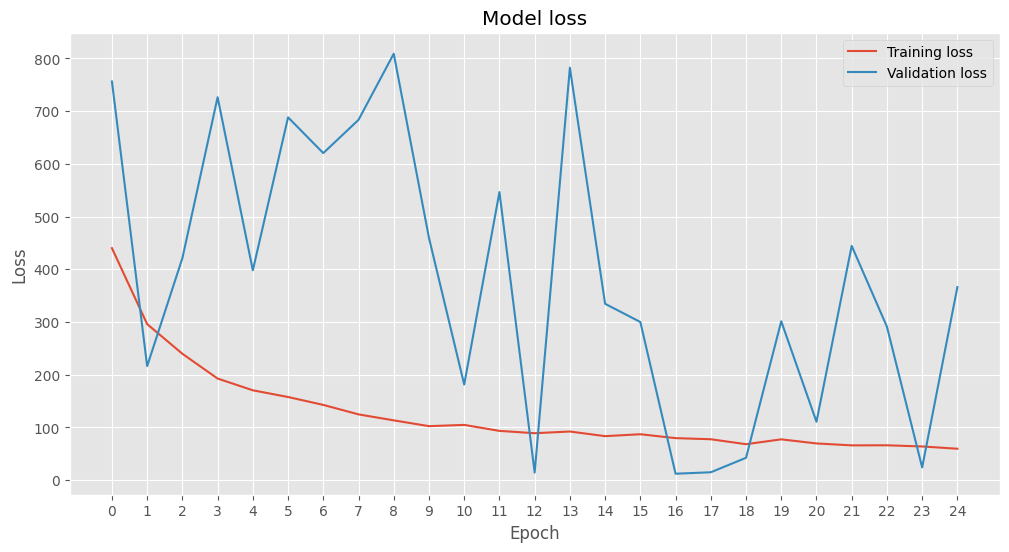

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 6))
plt.plot(losses[0][:,0], label='Training loss')
plt.plot(losses[0][:,1], label='Validation loss')
plt.xlabel('Epoch')
plt.xticks(range(0, EPOCHS))
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend(loc='upper right')

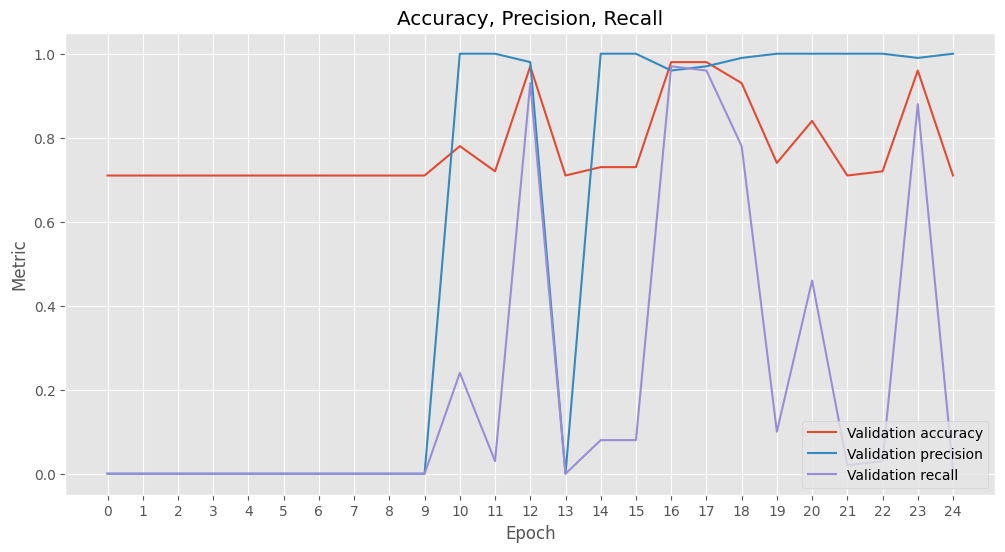

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 6))
plt.plot(losses[1][:,0], label='Validation accuracy')
plt.plot(losses[1][:,1], label='Validation precision')
plt.plot(losses[1][:,2], label='Validation recall')
plt.xlabel('Epoch')
plt.xticks(range(0, EPOCHS))
plt.ylabel('Metric')
plt.title('Accuracy, Precision, Recall')
plt.legend(loc='lower right')

IndexError: list index out of range

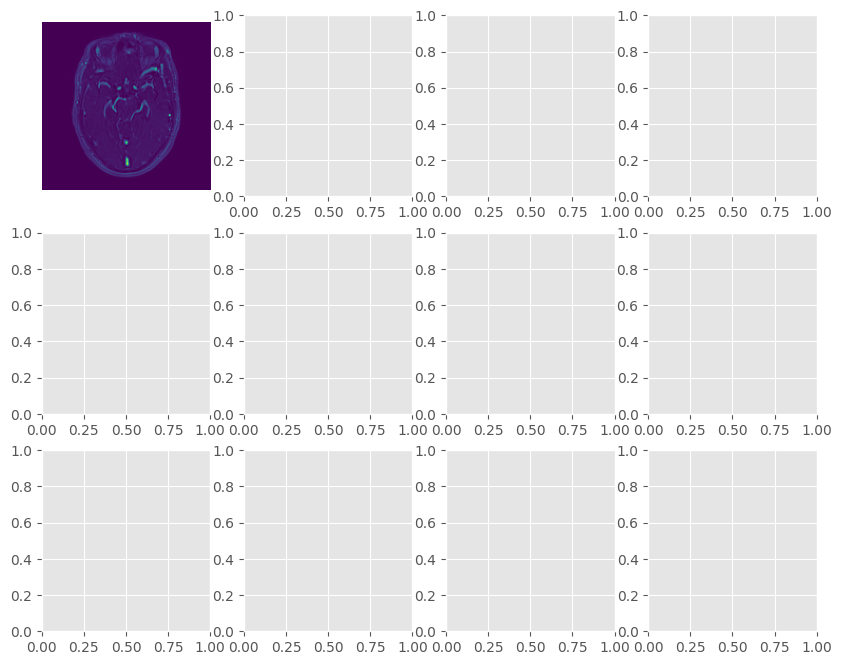

In [ ]:
# Displaying images with TP, TN, FN
# from visualization_utils import display_predictions
import random as rnd
def display_predictions(sorted_data):
    fig, axs = plt.subplots(3, 4, figsize=(10, 8))
    for i, ax in enumerate(axs):
        TP_image = rnd.choice(sorted_data[0])['ImagePath']
        ax[0].imshow(pdc.read_file(TP_image).pixel_array, cmap='viridis')
        ax[0].grid(False)
        ax[0].axis('off')
        FP_image = rnd.choice(sorted_data[1])['ImagePath']
        ax[1].imshow(pdc.read_file(FP_image).pixel_array, cmap='viridis')
        ax[1].grid(False)
        ax[1].axis('off')
        TN_image = rnd.choice(sorted_data[2])['ImagePath']
        ax[2].imshow(pdc.read_file(TN_image).pixel_array, cmap='viridis')
        ax[2].grid(False)
        ax[2].axis('off')
        FN_image = rnd.choice(sorted_data[3])['ImagePath']
        ax[3].imshow(pdc.read_file(FN_image).pixel_array, cmap='viridis')
        ax[3].grid(False)
        ax[3].axis('off')
        if i == 0:
            ax[0].set_title('True positive')
            ax[1].set_title('False positive')
            ax[2].set_title('True  negative')
            ax[3].set_title('False negative')
    fig.tight_layout()
display_predictions(train_sorted)
display_predictions(val_sorted)


In [ ]:
val_sorted[3]

[Patient                                      4
 Volume                                      13
 Slice                                        2
 ImagePath    D:/iCAT_IMAGES/004/004_20_578.dcm
 Name: 14892, dtype: object,
 Patient                                      4
 Volume                                      13
 Slice                                       20
 ImagePath    D:/iCAT_IMAGES/004/004_20_596.dcm
 Name: 14912, dtype: object,
 Patient                                      4
 Volume                                      13
 Slice                                       41
 ImagePath    D:/iCAT_IMAGES/004/004_20_617.dcm
 Name: 14936, dtype: object,
 Patient                                      9
 Volume                                      13
 Slice                                       17
 ImagePath    D:/iCAT_IMAGES/009/009_17_593.dcm
 Name: 34109, dtype: object,
 Patient                                      9
 Volume                                      13
 Slice              